In [14]:
# !pip install pandas
# !pip install imbalanced-learn
# !pip install seaborn
# !pip install graphviz
# !pip install sklearn
# !pip install xgboost
# !pip install numpy
# !pip install stopwords

import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
import re
import nltk
# nltk.download('stopwords')
# stemmer = nltk.SnowballStemmer("english")
import string
import csv

from sklearn.feature_extraction import text
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, LeaveOneOut, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics, svm, tree, preprocessing
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix,plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.metrics._plot.roc_curve import plot_roc_curve
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
# from imblearn.combine import SMOTETomek
# from imblearn.under_sampling import TomekLinks
from itertools import cycle
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.feature_selection import RFECV, SelectFromModel
from numpy import mean
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

In [15]:
# load cleaned data
df_sentiment = pd.read_csv("https://raw.githubusercontent.com/carolkkw/CIND820_Project/main/tweet_sentiment/data/Sentiment_Clean_Data.csv", sep =',', index_col=0)
df_sentiment = pd.DataFrame(df_sentiment)
df_sentiment = df_sentiment.rename(columns={'query':'service_name'})
df_sentiment['service_name'] = df_sentiment['service_name'].replace(['netflix','disneyplus','hulu','amazonprime'],['Netflix','Disney','Hulu','Amazon'])
df_sentiment.head(3)

,service_name,polarity,subjectivity
created_at_date,,,
2022-06-12,Netflix,0.000000,0.0
2022-06-12,Netflix,0.900000,0.9
2022-06-12,Netflix,0.333333,0.8


In [16]:
# check the mean of each service_name
df_sentiment2 = df_sentiment.groupby(['service_name']).mean().sort_values('polarity')
df_sentiment2.head()

,polarity,subjectivity
service_name,,
Hulu,-0.167940,0.521876
Disney,0.143134,0.334267
Amazon,0.154736,0.341622
Netflix,0.173216,0.376064


In [17]:
# check the mean of each service_name
df_sentiment3 = df_sentiment.groupby(['created_at_date','service_name'], sort=False).mean().reset_index()
df_sentiment3.head()

,created_at_date,service_name,polarity,subjectivity
0,2022-06-12,Netflix,0.142785,0.390704
1,2022-06-12,Disney,0.121732,0.366608
2,2022-06-12,Hulu,0.051658,0.405029
3,2022-06-12,Amazon,0.082957,0.266842
4,2022-06-13,Netflix,0.190237,0.400000


In [18]:
# check if null
df_sentiment3.isna().sum()

created_at_date    0
service_name       0
polarity           0
subjectivity       0
dtype: int64

In [19]:
# correlation

df_sentiment3.corr()

,polarity,subjectivity
polarity,1.0000,-0.7468
subjectivity,-0.7468,1.0000


<AxesSubplot:>

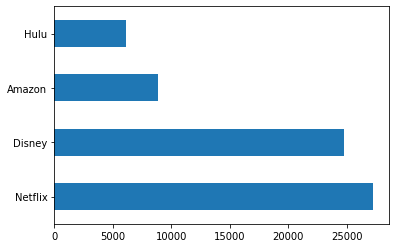

In [20]:
# check if data is imbalanced or not
df_sentiment['service_name'].value_counts().plot(kind='barh')

/opt/homebrew/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


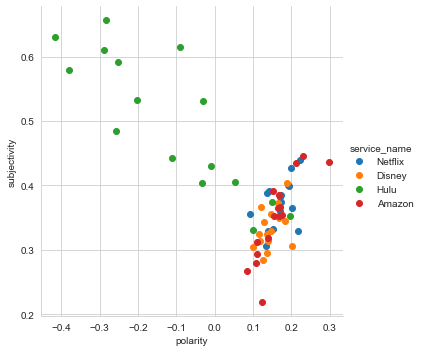

In [21]:
sns.set_style('whitegrid');
sns.FacetGrid(df_sentiment3, hue='service_name', size=5) \
.map(plt.scatter, 'polarity', 'subjectivity') \
.add_legend();
plt.show()

In [22]:
# normalize
df_normalize = df_sentiment3[['polarity','subjectivity']]
df_normalize = df_normalize.apply(lambda x:(x-x.min()) / (x.max()-x.min()))
df_normalize = df_normalize.join(df_sentiment3['service_name'])
df_normalize.head()

,polarity,subjectivity,service_name
0,0.782016,0.392285,Netflix
1,0.752619,0.337109,Disney
2,0.654772,0.425090,Hulu
3,0.698477,0.108660,Amazon
4,0.848275,0.413573,Netflix


In [23]:
df_normalize.describe()

,polarity,subjectivity
count,64.000000,64.000000
mean,0.707849,0.386185
std,0.216808,0.212781
min,0.000000,0.000000
25%,0.722029,0.251280
50%,0.777448,0.335345
75%,0.822075,0.437373
max,1.000000,1.000000


In [24]:
x = df_normalize[df_normalize.columns[:-1]]
y = df_normalize['service_name']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42, stratify=y)

In [25]:
# check y_test value before SMOTE
y_test.value_counts()

Netflix    5
Hulu       5
Disney     5
Amazon     5
Name: service_name, dtype: int64

Cross-validation in Logistic Regression Model

In [26]:
# Normal
logreg = LogisticRegression(random_state=42, solver="lbfgs", max_iter=1000)
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)
pipe = Pipeline([('model',logreg)])
logreg_pred = cross_val_predict(pipe, x, y, cv = cv)

print(confusion_matrix(y, logreg_pred))
print(classification_report(y, logreg_pred))

print("roc_auc:", cross_val_score(pipe, x, y, cv=cv, scoring='roc_auc_ovo').mean())

# Evaludate the efficiency
cv_results_logreg = cross_validate(pipe, x, y, cv=cv)

print("test score:", cv_results_logreg['test_score'].mean())
print("fit time:", cv_results_logreg['fit_time'].mean())
print("score time:", cv_results_logreg['score_time'].mean())

[[ 2  8  0  6]
 [ 4  7  0  5]
 [ 1  0 13  2]
 [ 4  4  0  8]]
              precision    recall  f1-score   support

      Amazon       0.18      0.12      0.15        16
      Disney       0.37      0.44      0.40        16
        Hulu       1.00      0.81      0.90        16
     Netflix       0.38      0.50      0.43        16

    accuracy                           0.47        64
   macro avg       0.48      0.47      0.47        64
weighted avg       0.48      0.47      0.47        64

roc_auc: 0.73125
test score: 0.4642857142857143
fit time: 0.0015444755554199219
score time: 0.00039446353912353516


Cross-validation in Random Forest Model

In [27]:
# Normal
ranfor = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=10, random_state = 42, shuffle = True)
pipe = Pipeline([('model',ranfor)])
ranfor_pred = cross_val_predict(pipe, x, y, cv = cv)

print(confusion_matrix(y, ranfor_pred))
print(classification_report(y, ranfor_pred))
print("roc_auc:", cross_val_score(pipe, x, y, cv=cv, scoring='roc_auc_ovo').mean())

# Evaludate the efficiency
cv_results_ranfor = cross_validate(pipe, x, y, cv=cv)

print("test score:", cv_results_ranfor['test_score'].mean())
print("fit time:", cv_results_ranfor['fit_time'].mean())
print("score time:", cv_results_ranfor['score_time'].mean())

[[ 6  5  0  5]
 [ 5  7  1  3]
 [ 1  1 12  2]
 [ 2  5  0  9]]
              precision    recall  f1-score   support

      Amazon       0.43      0.38      0.40        16
      Disney       0.39      0.44      0.41        16
        Hulu       0.92      0.75      0.83        16
     Netflix       0.47      0.56      0.51        16

    accuracy                           0.53        64
   macro avg       0.55      0.53      0.54        64
weighted avg       0.55      0.53      0.54        64

roc_auc: 0.7635416666666667
test score: 0.5261904761904761
fit time: 0.037253618240356445
score time: 0.002786111831665039


In [28]:
# new input to predict class
new_input = np.array([[10,0], 
                      [10,0.2],
                      [10,0.3],
                      [10,0.5],
                      [10,0.7]
                      
                      
                      ])

new_table = pd.DataFrame(new_input, columns = ["polarity","subjectivity"])

In [29]:
ranfor = RandomForestClassifier(random_state=42)
ranfor.fit(x, y)
new_output = ranfor.predict(new_table)
new_pred = new_table
new_pred['predict'] = pd.DataFrame(new_output, columns=['predict'])
print(new_pred)

   polarity  subjectivity  predict
0      10.0           0.0   Amazon
1      10.0           0.2   Disney
2      10.0           0.3  Netflix
3      10.0           0.5   Amazon
4      10.0           0.7   Amazon
